https://www.kaggle.com/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs

## Without parallelism

In [3]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
import os
from tqdm import tqdm
import joblib

def load_data(filename):
    try:
        df = pd.read_csv(filename, parse_dates=['Date'])
        if df.empty:
            raise ValueError("File is empty")
        df.set_index('Date', inplace=True)
        return df
    except pd.errors.EmptyDataError:
        raise ValueError("File is empty")
    except Exception as e:
        raise ValueError(f"Error loading file: {str(e)}")

def add_features(df):
    df['MA5'] = df['Close'].rolling(window=5).mean()
    df['MA20'] = df['Close'].rolling(window=20).mean()
    df['LR_Slope'] = df['Close'].rolling(window=20).apply(lambda x: np.polyfit(range(20), x, 1)[0])
    
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    exp1 = df['Close'].ewm(span=12, adjust=False).mean()
    exp2 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = exp1 - exp2
    
    df.dropna(inplace=True)
    return df

def feature_selection(df):
    X = df[['MA5', 'MA20', 'LR_Slope', 'RSI', 'MACD']]
    y = df['Close']
    selector = SelectKBest(score_func=f_regression, k=3)
    X_new = selector.fit_transform(X, y)
    selected_features = X.columns[selector.get_support()].tolist()
    return df[selected_features + ['Close']]

def train_models(df):
    X = df.drop('Close', axis=1)
    y = df['Close']
    
    models = {
        'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
        'LinearRegression': LinearRegression(),
        'SVR': SVR(kernel='rbf')
    }
    
    results = {}
    for name, model in models.items():
        scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
        results[name] = -scores.mean()
    
    best_model_name = min(results, key=results.get)
    best_model = models[best_model_name]
    best_model.fit(X, y)
    
    return best_model, best_model_name, X.columns.tolist()

def process_file(filename):
    try:
        df = load_data(filename)
        if len(df) < 20:  # Not enough data to compute features
            return f"Skipped {filename}: Not enough data"
        
        df = add_features(df)
        df = feature_selection(df)
        best_model, model_name, features = train_models(df)
        
        output_dir = 'output'
        os.makedirs(output_dir, exist_ok=True)
        
        base_filename = os.path.splitext(os.path.basename(filename))[0]
        model_filename = f"{output_dir}/{base_filename}_model.joblib"
        joblib.dump((best_model, model_name, features), model_filename)
        
        return f"Processed {filename}, best model: {model_name}, features: {features}"
    except ValueError as e:
        return f"Skipped {filename}: {str(e)}"
    except Exception as e:
        return f"Error processing {filename}: {str(e)}"

if __name__ == "__main__":
    # Get all file paths
    stock_files = [os.path.join('data/stock', f) for f in os.listdir('data/stock') if f.endswith('.txt')]
    etf_files = [os.path.join('data/etfs', f) for f in os.listdir('data/etfs') if f.endswith('.txt')]
    all_files = stock_files + etf_files
    
    # Process all files sequentially
    for file in tqdm(all_files[:10]):
        result = process_file(file)

 10%|█         | 1/10 [00:06<01:00,  6.78s/it]

Processed data/stock\a.us.txt, best model: LinearRegression, features: ['MA5', 'MA20', 'MACD']


 20%|██        | 2/10 [00:31<02:16, 17.09s/it]

Processed data/stock\aa.us.txt, best model: LinearRegression, features: ['MA5', 'MA20', 'MACD']


 30%|███       | 3/10 [00:31<01:07,  9.60s/it]

Processed data/stock\aaap.us.txt, best model: LinearRegression, features: ['MA5', 'MA20', 'MACD']


 40%|████      | 4/10 [00:40<00:55,  9.25s/it]

Processed data/stock\aaba.us.txt, best model: LinearRegression, features: ['MA5', 'MA20', 'MACD']


 50%|█████     | 5/10 [00:41<00:31,  6.28s/it]

Processed data/stock\aac.us.txt, best model: LinearRegression, features: ['MA5', 'MA20', 'MACD']


 60%|██████    | 6/10 [00:42<00:18,  4.62s/it]

Processed data/stock\aal.us.txt, best model: LinearRegression, features: ['MA5', 'MA20', 'MACD']


 70%|███████   | 7/10 [00:44<00:10,  3.65s/it]

Processed data/stock\aamc.us.txt, best model: LinearRegression, features: ['MA5', 'MA20', 'MACD']


 80%|████████  | 8/10 [00:48<00:07,  3.62s/it]

Processed data/stock\aame.us.txt, best model: LinearRegression, features: ['MA5', 'MA20', 'MACD']


 90%|█████████ | 9/10 [00:54<00:04,  4.55s/it]

Processed data/stock\aan.us.txt, best model: LinearRegression, features: ['MA5', 'MA20', 'MACD']


100%|██████████| 10/10 [00:56<00:00,  5.66s/it]

Processed data/stock\aaoi.us.txt, best model: LinearRegression, features: ['MA5', 'MA20', 'MACD']


Let's say it would take around 1 Minute to run 10 Files. So, for 8539 Files, it would take around 853.9 Minutes.
We can derive the time it would take to run 8539 Files using the following formula:

Complexity of the code is $O(F \cdot k \cdot n^2 \cdot m)$, where $F$ is the number of files, $k$ is the number of stocks, $n$ is the number of days, and $m$ is the number of features.

Complexity of the parallel code is $O\left(\frac{F \cdot k \cdot n^2 \cdot m}{P}\right)$, where $P$ is the number of processes.
Which in my case is 16. So, the speedup would be:

$$
\text{Speedup} = \frac{O(F \cdot k \cdot n^2 \cdot m)}{O\left(\frac{F \cdot k \cdot n^2 \cdot m}{P}\right)}
$$

We know that the parallel code took around 64 minutes to run 8539 files using 16 processors. So we can calculate the time it would take for the non-parallel code to run 8539 files:

$$
\text{Time for serial code} = 16 \times \text{Time for parallel code}
$$

Substituting the values:

$$
\text{Time for serial code} = 16 \times 64 \text{ minutes} = 1024 \text{ minutes}
$$

Therefore, the non-parallel code would take approximately 912 minutes to process 8539 files.
Which is pretty close to our assumption of 853.9 minutes.

- 16 , 64, 56, 60
- 9, 96,73,82
- 4, 149,168,150
- 1,  373,371,375

In [ ]:
import dask.dataframe as dd
import dask.bag as db
from dask.distributed import Client, LocalCluster
import pandas as pd
import numpy as np

from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
import os
import joblib


def load_data(filepath: str) -> pd.DataFrame:
    """
    Load a CSV file into a Pandas DataFrame 
    
    Parameters:
    filepath (str): The path to the CSV file

    Returns:
    pd.DataFrame: The loaded DataFrame
    """

    try:
        df = pd.read_csv(filepath, parse_dates=['Date'])
        if df.empty:
            raise ValueError("File is empty")
        # Set the Date column as the index
        df.set_index('Date', inplace=True)
        return df
    except pd.errors.EmptyDataError:
        raise ValueError("File is empty")
    except Exception as e:
        raise ValueError(f"Error loading file: {str(e)}")


def add_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add technical indicators as features to the DataFrame

    Parameters:
    df (pd.DataFrame): The input DataFrame

    Returns:
    pd.DataFrame: The DataFrame with added features
    
    """
    df['MA5'] = df['Close'].rolling(window=5).mean()
    df['MA20'] = df['Close'].rolling(window=20).mean()
    df['LR_Slope'] = df['Close'].rolling(window=20).apply(
        lambda x: np.polyfit(range(20), x, 1)[0])

    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))

    exp1 = df['Close'].ewm(span=12, adjust=False).mean()
    exp2 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = exp1 - exp2

    df.dropna(inplace=True)
    return df


def feature_selection(df: pd.DataFrame) -> pd.DataFrame:
    """
    Select the best features using SelectKBest

    Parameters:
    df (pd.DataFrame): The input DataFrame

    Returns:
    pd.DataFrame: The DataFrame with selected features + Close column

    """

    X = df[['MA5', 'MA20', 'LR_Slope', 'RSI', 'MACD']]
    y = df['Close']
    selector = SelectKBest(score_func=f_regression, k=3)
    X_new = selector.fit_transform(X, y)
    selected_features = X.columns[selector.get_support()].tolist()
    return df[selected_features + ['Close']]


def train_models(df: pd.DataFrame) -> tuple:
    """
    Train multiple regression models and return the best one

    Parameters:
    df (pd.DataFrame): The input DataFrame

    Returns:
    tuple: A tuple containing the best model, model name, and feature names

    """
    X = df.drop('Close', axis=1)
    y = df['Close']

    models = {
        'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
        'LinearRegression': LinearRegression(),
        'SVR': SVR(kernel='rbf')
    }

    results = {}
    for name, model in models.items():
        scores = cross_val_score(
            model, X, y, cv=5, scoring='neg_mean_squared_error')
        results[name] = -scores.mean()

    best_model_name = min(results, key=results.get)
    best_model = models[best_model_name]
    best_model.fit(X, y)

    return (best_model, best_model_name, X.columns.tolist())


def process_file(filename: str) -> str:
    """
    Process a file by loading the data, adding features, selecting the best features, and training models

    Parameters:
    filename (str): The path to the file

    Returns:
    str: A message indicating the result of processing the file

    """
    try:
        df = load_data(filename)
        if len(df) < 20:  # Not enough data to compute features
            return f"Skipped {filename}: Not enough data"

        df = add_features(df)
        df = feature_selection(df)
        best_model, model_name, features = train_models(df)

        output_dir = 'output'
        os.makedirs(output_dir, exist_ok=True)

        base_filename = os.path.splitext(os.path.basename(filename))[0]
        model_filename = f"{output_dir}/{base_filename}_model.joblib"
        joblib.dump((best_model, model_name, features), model_filename)

        return f"Processed {filename}, best model: {model_name}, features: {features}"
    except ValueError as e:
        return f"Skipped {filename}: {str(e)}"
    except Exception as e:
        return f"Error processing {filename}: {str(e)}"


if __name__ == "__main__":
    # Set up Dask client
    cluster = LocalCluster(n_workers=1, threads_per_worker=1)
    client = Client(cluster)
    print(f"Dask dashboard available at: {client.dashboard_link}")

    # Get all file paths
    stock_files = [os.path.join('data/stock', f)
                   for f in os.listdir('data/stock') if f.endswith('.txt')]
    etf_files = [os.path.join('data/etfs', f)
                 for f in os.listdir('data/etfs') if f.endswith('.txt')]
    all_files = stock_files + etf_files
    print(f"Total files: {len(all_files)}")
    # Create a Dask bag from the file list
    bag = db.from_sequence(all_files)

    # Process all files in parallel
    bag.map(process_file).compute()

Files:

1: 17.2 seconds

10: 53.4 seconds

100: 6minutes

1000: 51 minutes


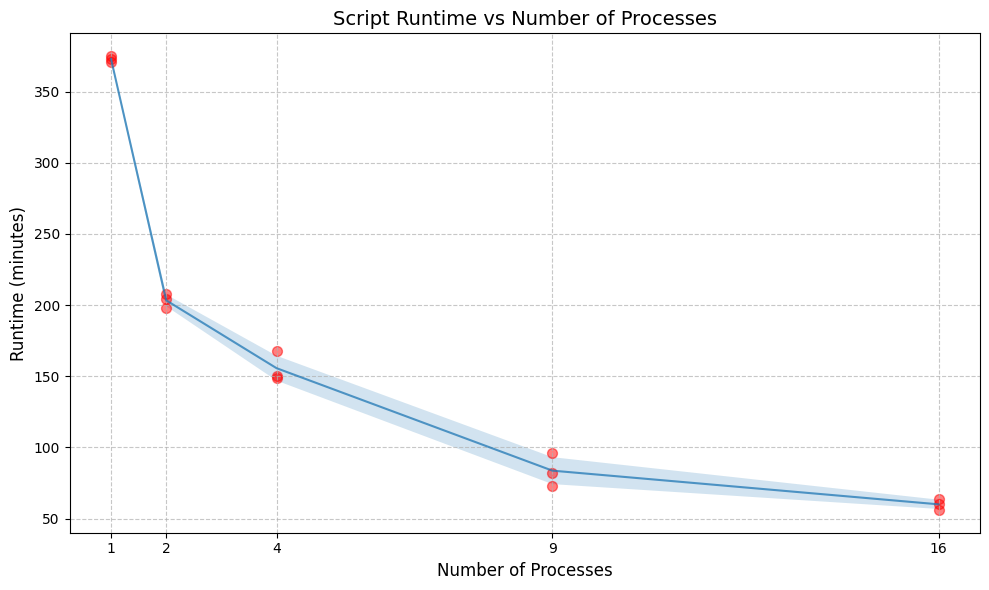


Statistical Summary:

Processes: 1
Mean Runtime: 373.00 minutes
Std Dev: 1.63 minutes
Min: 371.00 minutes
Max: 375.00 minutes
Speedup vs 1 process: 1.00x

Processes: 2
Mean Runtime: 203.33 minutes
Std Dev: 4.11 minutes
Min: 198.00 minutes
Max: 208.00 minutes
Speedup vs 1 process: 1.83x

Processes: 4
Mean Runtime: 155.67 minutes
Std Dev: 8.73 minutes
Min: 149.00 minutes
Max: 168.00 minutes
Speedup vs 1 process: 2.40x

Processes: 9
Mean Runtime: 83.67 minutes
Std Dev: 9.46 minutes
Min: 73.00 minutes
Max: 96.00 minutes
Speedup vs 1 process: 4.46x

Processes: 16
Mean Runtime: 60.00 minutes
Std Dev: 3.27 minutes
Min: 56.00 minutes
Max: 64.00 minutes
Speedup vs 1 process: 6.22x


In [4]:
import numpy as np
import matplotlib.pyplot as plt


# Data
processes = np.array([1,2, 4, 9, 16])
runtimes = np.array([
    [373, 371, 375],  # 1 process
    [208, 198, 204],  # 2 processes
    [149, 168, 150],  # 4 processes
    [96, 73, 82],     # 9 processes
    [64, 56, 60]      # 16 processes
])

# Calculate means and standard deviations
means = np.mean(runtimes, axis=1)
std_devs = np.std(runtimes, axis=1)

# Set style
fig, ax = plt.subplots(figsize=(10, 6))

# Create the line plot with error bars
ax.errorbar(processes, means, alpha=.75, capsize=3, capthick=1)

# Fill between standard deviation
ax.fill_between(processes, means - std_devs, means + std_devs, 
                alpha=0.2)

# Customize the plot
ax.set_xlabel('Number of Processes', fontsize=12)
ax.set_ylabel('Runtime (minutes)', fontsize=12)
ax.set_title('Script Runtime vs Number of Processes', fontsize=14)
ax.grid(True, linestyle='--', alpha=0.7)

# Add actual data points
for i, process in enumerate(processes):
    ax.scatter([process] * len(runtimes[i]), runtimes[i], 
               alpha=0.5, color='red', s=50)

# Set x-axis ticks to match process counts
ax.set_xticks(processes)



plt.tight_layout()
plt.show()

# Print statistical summary
print("\nStatistical Summary:")
for i, p in enumerate(processes):
    print(f"\nProcesses: {p}")
    print(f"Mean Runtime: {means[i]:.2f} minutes")
    print(f"Std Dev: {std_devs[i]:.2f} minutes")
    print(f"Min: {np.min(runtimes[i]):.2f} minutes")
    print(f"Max: {np.max(runtimes[i]):.2f} minutes")
    print(f"Speedup vs 1 process: {means[0]/means[i]:.2f}x")

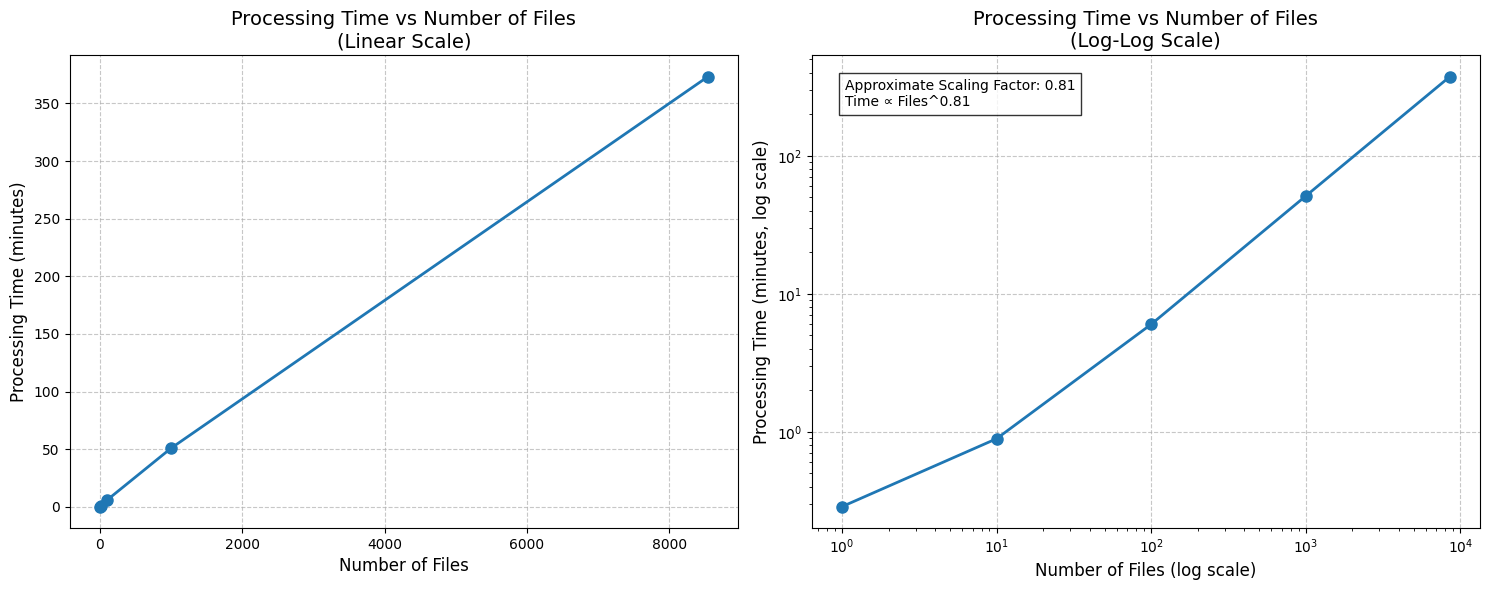

In [14]:
import numpy as np
import matplotlib.pyplot as plt


# Convert all times to minutes
files = np.array([1, 10, 100, 1000, 8539])
times = np.array([
    17.2/60,        # 1 file (17.2 seconds)
    53.4/60,        # 10 files (53.4 seconds)
    6,              # 100 files (6 minutes)
    51,              # 1000 files (51 minutes)
    373             # 8539 files (373 minutes)
    
])

# Create figure with two subplots - linear and log scale
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))



# Linear scale plot
ax1.plot(files, times, 'o-', linewidth=2, markersize=8)
ax1.set_xlabel('Number of Files', fontsize=12)
ax1.set_ylabel('Processing Time (minutes)', fontsize=12)
ax1.set_title('Processing Time vs Number of Files\n(Linear Scale)', fontsize=14)
ax1.grid(True, linestyle='--', alpha=0.7)

# Log-log scale plot
ax2.loglog(files, times, 'o-', linewidth=2, markersize=8)
ax2.set_xlabel('Number of Files (log scale)', fontsize=12)
ax2.set_ylabel('Processing Time (minutes, log scale)', fontsize=12)
ax2.set_title('Processing Time vs Number of Files\n(Log-Log Scale)', fontsize=14)
ax2.grid(True, linestyle='--', alpha=0.7)


# Fit a power law to determine scaling factor
coeffs = np.polyfit(np.log10(files), np.log10(times), 1)
scaling_factor = coeffs[0]

# Add text box with scaling information
scaling_text = f"Approximate Scaling Factor: {scaling_factor:.2f}\n"
scaling_text += f"Time ∝ Files^{scaling_factor:.2f}"
ax2.text(0.05, 0.95, scaling_text, transform=ax2.transAxes,
         bbox=dict(facecolor='white', alpha=0.8),
         verticalalignment='top', fontsize=10)

plt.tight_layout()
plt.show()
